In [1]:
# Import libraries
import numpy as np
from numpy import zeros, ones, vstack, expand_dims
from numpy.random import randn, randint

import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Resizing, Input, UpSampling2D, MaxPooling2D, Flatten, Conv2DTranspose, LeakyReLU, Reshape, Dropout, BatchNormalization, GlobalMaxPooling2D, GlobalAveragePooling2D, Add, AveragePooling2D
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
from keras import Model
from keras.utils import plot_model
from keras import backend

from skimage.transform import resize
from matplotlib import pyplot as plt

In [2]:
# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 )
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train)
cifar10_test = tfds.as_numpy(cifar10_test)

# Seperate feature X and label Y
X_train, y_train = cifar10_train["image"], cifar10_train["label"]
X_test, y_test = cifar10_test["image"], cifar10_test["label"]

# Print shapes of the entire training and test set of CIFAR 10
print("X_train shape: " + str(X_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_train shape: " + str(y_train.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
y_train shape: (50000,)
y_test shape: (10000,)


In [3]:
# Get samples  of a certain label
label = 5 # Class '1' is car. You may change this label to another class label. I changed in dogs
train_indices = np.where(y_train == label) # Get indices of the label
train_set = X_train[train_indices] # Get train samples of the label
test_indices = np.where(y_test == label) # Get indices of the label
test_set = X_train[test_indices] # Get test samples of the label

# Print shapes of datasets of the selected class
print("train_set shape of the selected class: " + str(train_set.shape))
print("test_set shape of the selected class: " + str(test_set.shape))

# NOTE: training a GAN does not require to have train/test split. All data samples of the training and the test set are used as real data samples.
# You should merge the training and the test set to get more real data samples, i.e., merge the train_set and the test_set to one dataset which is the real dataset.

train_set shape of the selected class: (5000, 32, 32, 3)
test_set shape of the selected class: (1000, 32, 32, 3)


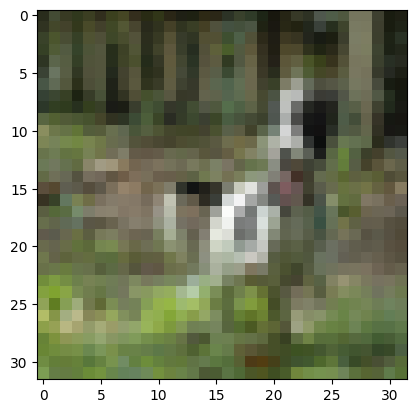

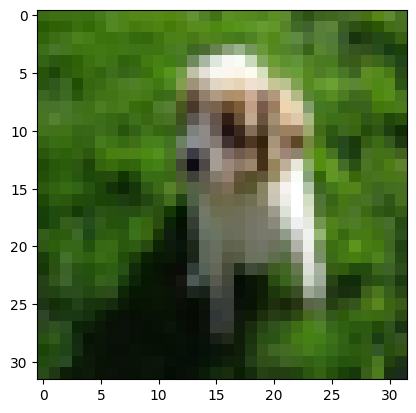

In [4]:
# Visualize some data samples of class '1' (car)
import matplotlib.pyplot as plt
imgplot = plt.imshow(train_set[0])
plt.show()
imgplot = plt.imshow(train_set[1])
plt.show()

In [20]:
def resizeXReal(XReal, imgSize = 32):
    return Resizing(imgSize, imgSize)(XReal)

In [21]:
def add_dis_block(old_model, n_input_layers = 3, n_filters = 256):
  in_shape = list(old_model.input.shape)

	# define new input shape as double the size
  input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
  in_image = Input(shape=input_shape)
  # define new input processing layer (fromRGB)
  d = Conv2D(n_filters, (1,1), padding='same')(in_image)
  d = LeakyReLU(alpha=0.2)(d)
	# define new block
  d = Conv2D(n_filters, (3,3), padding='same')(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(n_filters, (3,3), padding='same')(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = AveragePooling2D()(d)
# skip the input, 1x1 and activation for the old model
  for i in range(n_input_layers, len(old_model.layers)):
	  d = old_model.layers[i](d)
# define straight-through model
  model = Model(in_image, d)
  return model

In [22]:
def discriminator(n_blocks, input_shape = (4,4,3)):
  model_list = list()
  in_image = Input(input_shape)
  # Conv2D 1x1
  d = Conv2D(256, (1,1), padding = 'same')(in_image)
  d = LeakyReLU(alpha = 0.2)(d)
  # Conv2D 3x3
  d = Conv2D(256, (3,3), padding = 'same')(d)
  d = LeakyReLU(alpha = 0.2)(d)
  # Conv2D 4x4
  d = Conv2D(256, (4,4), padding = 'same')(d)
  d = LeakyReLU(alpha = 0.2)(d)
  #
  d = Conv2D(256, (5,5), padding = 'same')(d)
  d = LeakyReLU(alpha = 0.2)(d)


  # # BatchNormalization
  # d = BatchNormalization()(d)
  # d = LeakyReLU(alpha = 0.2)(d)
  # Dense
  d = Flatten()(d)
  out_class = Dense(1, activation = 'sigmoid')(d)

  model = Model(in_image, out_class)

  model_list.append(model)

  for i in range(1, n_blocks):
    old_model = model_list[i-1]
    models = add_dis_block(old_model)
    model_list.append(models)

  return model_list

In [33]:
def add_gen_block(old_model, num_filters = 1024):
  block_end = old_model.layers[-2].output

  # Upsampling and define new blocks
  block_end = old_model.layers[-2].output

	# upsample, and define new block
  upsampling = UpSampling2D()(block_end)
  g = Conv2D(num_filters, (3,3), padding='same', strides=(1,1))(upsampling)
  g = LeakyReLU(alpha=0.2)(g)
  g = Conv2D(num_filters, (3,3), padding='same', strides=(1,1))(g)
  g = LeakyReLU(alpha=0.2)(g)
  # add new output layer (toRGB)
  out_image = Conv2D(3, (1,1), padding='same', strides=(1,1), activation='tanh')(g)
  # define model
  model = Model(old_model.input, out_image)
  return model

In [34]:
# define generator models
def generator(latent_dim, n_blocks, in_dim=4):
	model_list = list()
	# base model latent input
	in_latent = Input(shape=(latent_dim,))

	# linear scale up to activation maps
	g  = Dense(512 * in_dim * in_dim)(in_latent)
	g = LeakyReLU(alpha=0.2)(g)
	g = Reshape((in_dim, in_dim, 512))(g)

	# conv 4x4, input block
	g = Conv2D(512, (3,3), padding='same', strides=(1,1))(g)
	g = LeakyReLU(alpha=0.2)(g)

	# conv 3x3
	g = Conv2D(512, (3,3), padding='same', strides=(1,1))(g)
	g = LeakyReLU(alpha=0.2)(g)

  # #BatchNormalization
	# g = BatchNormalization()(g)
	# g = LeakyReLU(alpha = 0.2)(g)

	# conv 1x1, output block (toRGB)
	out_image = Conv2D(3, (1,1), padding='valid', strides=(1,1), activation='tanh')(g)

	# define model
	model = Model(in_latent, out_image)

	# store model
	model_list.append(model)

	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1]
		# create new model for next resolution
		models = add_gen_block(old_model)
		# store model
		model_list.append(models)
	return model_list

In [35]:
discriminators = discriminator(4)
discriminators[1].summary()


Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 8, 8, 3)]         0         
                                                                 
 conv2d_66 (Conv2D)          (None, 8, 8, 256)         1024      
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_67 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_68 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 8, 8, 256)         0  

In [36]:
generators = generator(128, 4)
generators[1].summary()


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_75 (Conv2D)          (None, 4, 4, 512)         2359808   
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_76 (Conv2D)          (None, 4, 4, 512)         235

In [27]:
# Define the GAN network consisting of a Generator and a Discriminator
def define_gan(g_model, d_model):
    # g_model: Generator component
    # d_model: Discriminator component

    model = Sequential() # Initialize a sequential model
    model.add(g_model) # Add the Generator component
    model.add(d_model) # Add the Discriminator component
    return model # Return the GAN

In [28]:
def norm_sample():
  X = X_train.astype('float32')
  X = (X - 127.5)/127.5
  return X

def sample_generate(ds, sample_num):
  index = randint(0, ds.shape[0], sample_num)
  X = ds[index]
  y = ones((sample_num, 1))
  return X,y

In [29]:
def latent_point(latent_dim, sample_num):
  x_in = randn(latent_dim*sample_num)
  x_in = x_in.reshape(sample_num, latent_dim)
  return x_in

def gen_fake(g_model, latent_dim, sample_num):
  x_in = latent_point(latent_dim, sample_num)
  X = g_model.predict(x_in)
  y = zeros((sample_num, 1))
  return X,y

In [30]:
# Create and save a plot of generated images
def save_plot(samples, epoch, n=10):
    # Define a plot of (n rows, n columns)
    for i in range(n * n):
        # (1+i) is the index position on a grid with nrows rows and ncols columns. Index starts at 1 in the upper left corner and increases to the right.
        plt.subplot(n, n, 1+i)
        plt.axis('off') # Disable axis
        plt.imshow(samples[i, :, :, :]) # Plot the sample i with reversed gay color map
    filename = 'Plot_epoch_%03d.png' % (epoch+1)
    plt.savefig(filename) # Save plot to file
    plt.close() # Close the plot

# Saving the model so that I can continue training after Colab crashes/OOM
def saveModel(D, G, GAN, atEpoch):
    DName = 'D_epoch_%03d' % (atEpoch)
    GName = 'G_epoch_%03d' % (atEpoch)
    GANName = 'GAN_epoch_%03d' % (atEpoch)

    D.save(DName, save_format = 'tf')
    G.save(GName, save_format = 'tf')
    GAN.save(GANName, save_format = 'tf')
    pass

In [31]:
# Train the Generator and the Discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=201, n_batch=4096):
    bat_per_epo = int(dataset.shape[0] / n_batch) # Number of iterations per epoch
    half_batch = int(n_batch / 2) # A batch to the Discriminator contains real samples (half-batch) and fake samples (half-batch)

    d_loss_values = [] # Array containing Discriminator loss over iterations
    g_loss_values = [] # Array containing Generator loss over iterations

    # Number of epochs
    for i in range(n_epochs):
        # Number of iterations
        for j in range(bat_per_epo):

            # Randomly get half_batch real data samples from the real dataset
            X_real, y_real = sample_generate(dataset, half_batch)
            # Generate half_batch fake data samples
            X_fake, y_fake = gen_fake(g_model, latent_dim, half_batch)
            # Create training set for the discriminator: half-batch real and half-batch fake
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            # Update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)

            # Generate random latent vectors as input for Generator
            X_gan = latent_point(latent_dim, n_batch)
            # Generate inverted labels for the fake samples to train the Generator
            y_gan = ones((n_batch, 1))
            # Train the Generator
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Training log after every iteration
            print('Epoch %d, Iteration %d/%d, D_loss = %.3f, G_loss = %.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # Add loss values to historical arrays
            d_loss_values.append(d_loss)
            g_loss_values.append(g_loss)

        # Plot the generated images and save the model every certain number of epochs
        if (i+1) % 10 == 0: # every 10 epochs
            X_fake, _ = gen_fake(g_model, latent_dim, 100) # Generate 100 fake data samples using the Generator. Pixel values are in [0,1]
            save_plot(X_fake, i, n=10) # Plot a grid of 10x10 fake samples and save to file at epoch i
            saveModel(d_model, g_model, gan_model, i) # Saving all three models

    return d_loss_values, g_loss_values # Return the loss arrays of Generator and Discriminator

# Training Phase

4x4

In [37]:
# Size of the latent space
latent_dim = 128
epochs = 151
batch_size = 512

# Initialize an optimizer. Pick one.
opt = Adam(learning_rate=0.0001, beta_1=0.5) # Adam optimizer with customized values (for the best result)
# opt = Adam() # Adam optimizer with default values
# opt = SGD() # SGD optimizer with default values

# Discriminator
dis_4x4 = discriminators[0]
dis_4x4.trainable = True
dis_4x4.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

#Generator
gen_4x4 = generators[0]

#Define GAN
dis_4x4.trainable = False
GAN_4x4 = define_gan(gen_4x4, dis_4x4)
GAN_4x4.compile(loss = 'binary_crossentropy', optimizer = opt)

#Load real samples
ds = norm_sample()
ds_4x4 = resizeXReal(ds, imgSize = 4)._numpy()

#Train
d_losses, g_losses = train(gen_4x4, dis_4x4, GAN_4x4, ds_4x4, latent_dim, epochs, batch_size)


8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 1/97, D_loss = 0.695, G_loss = 0.690
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 2/97, D_loss = 0.683, G_loss = 0.681
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 3/97, D_loss = 0.678, G_loss = 0.681
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 4/97, D_loss = 0.683, G_loss = 0.692
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 5/97, D_loss = 0.669, G_loss = 0.740
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 6/97, D_loss = 0.647, G_loss = 0.775
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 7/97, D_loss = 0.657, G_loss = 0.820
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 8/97, D_loss = 0.627, G_loss = 0.868
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 9/97, D_loss = 0.765, G_loss = 0.759
8/8 [==============================] 

8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 1/97, D_loss = 0.687, G_loss = 0.695
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 2/97, D_loss = 0.693, G_loss = 0.713
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 3/97, D_loss = 0.696, G_loss = 0.722
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 4/97, D_loss = 0.702, G_loss = 0.734
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 5/97, D_loss = 0.701, G_loss = 0.750
8/8 [==============================] - 0s 3ms/step
Epoch 11, Iteration 6/97, D_loss = 0.706, G_loss = 0.761
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 7/97, D_loss = 0.703, G_loss = 0.799
8/8 [==============================] - 0s 3ms/step
Epoch 11, Iteration 8/97, D_loss = 0.689, G_loss = 0.813
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 9/97, D_loss = 0.684, G_loss = 0.831
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 1/97, D_loss = 0.675, G_loss = 0.763
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 2/97, D_loss = 0.685, G_loss = 0.754
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 3/97, D_loss = 0.681, G_loss = 0.748
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 4/97, D_loss = 0.693, G_loss = 0.737
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 5/97, D_loss = 0.702, G_loss = 0.727
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 6/97, D_loss = 0.702, G_loss = 0.714
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 7/97, D_loss = 0.692, G_loss = 0.710
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 8/97, D_loss = 0.707, G_loss = 0.699
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 9/97, D_loss = 0.710, G_loss = 0.703
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 1/97, D_loss = 0.689, G_loss = 0.706
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 2/97, D_loss = 0.685, G_loss = 0.707
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 3/97, D_loss = 0.684, G_loss = 0.710
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 4/97, D_loss = 0.682, G_loss = 0.709
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 5/97, D_loss = 0.689, G_loss = 0.718
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 6/97, D_loss = 0.682, G_loss = 0.716
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 7/97, D_loss = 0.679, G_loss = 0.715
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 8/97, D_loss = 0.683, G_loss = 0.715
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 9/97, D_loss = 0.681, G_loss = 0.717
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 1/97, D_loss = 0.673, G_loss = 0.731
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 2/97, D_loss = 0.675, G_loss = 0.732
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 3/97, D_loss = 0.671, G_loss = 0.734
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 4/97, D_loss = 0.672, G_loss = 0.727
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 5/97, D_loss = 0.674, G_loss = 0.716
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 6/97, D_loss = 0.678, G_loss = 0.708
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 7/97, D_loss = 0.678, G_loss = 0.696
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 8/97, D_loss = 0.677, G_loss = 0.692
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 9/97, D_loss = 0.688, G_loss = 0.688
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 1/97, D_loss = 0.695, G_loss = 0.691
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 2/97, D_loss = 0.695, G_loss = 0.692
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 3/97, D_loss = 0.692, G_loss = 0.693
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 4/97, D_loss = 0.689, G_loss = 0.699
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 5/97, D_loss = 0.687, G_loss = 0.703
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 6/97, D_loss = 0.686, G_loss = 0.707
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 7/97, D_loss = 0.683, G_loss = 0.714
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 8/97, D_loss = 0.683, G_loss = 0.718
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 9/97, D_loss = 0.678, G_loss = 0.725
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 1/97, D_loss = 0.700, G_loss = 0.703
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 2/97, D_loss = 0.696, G_loss = 0.711
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 3/97, D_loss = 0.692, G_loss = 0.706
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 4/97, D_loss = 0.696, G_loss = 0.713
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 5/97, D_loss = 0.687, G_loss = 0.715
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 6/97, D_loss = 0.691, G_loss = 0.721
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 7/97, D_loss = 0.687, G_loss = 0.720
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 8/97, D_loss = 0.692, G_loss = 0.713
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 9/97, D_loss = 0.691, G_loss = 0.706
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 1/97, D_loss = 0.691, G_loss = 0.703
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 2/97, D_loss = 0.690, G_loss = 0.703
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 3/97, D_loss = 0.690, G_loss = 0.709
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 4/97, D_loss = 0.690, G_loss = 0.712
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 5/97, D_loss = 0.688, G_loss = 0.715
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 6/97, D_loss = 0.686, G_loss = 0.716
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 7/97, D_loss = 0.690, G_loss = 0.716
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 8/97, D_loss = 0.690, G_loss = 0.710
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 9/97, D_loss = 0.693, G_loss = 0.710
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 1/97, D_loss = 0.702, G_loss = 0.698
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 2/97, D_loss = 0.702, G_loss = 0.694
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 3/97, D_loss = 0.707, G_loss = 0.691
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 4/97, D_loss = 0.702, G_loss = 0.691
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 5/97, D_loss = 0.709, G_loss = 0.688
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 6/97, D_loss = 0.708, G_loss = 0.692
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 7/97, D_loss = 0.706, G_loss = 0.702
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 8/97, D_loss = 0.695, G_loss = 0.710
8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 9/97, D_loss = 0.690, G_loss = 0.716
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 1/97, D_loss = 0.703, G_loss = 0.665
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 2/97, D_loss = 0.691, G_loss = 0.661
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 3/97, D_loss = 0.691, G_loss = 0.658
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 4/97, D_loss = 0.689, G_loss = 0.658
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 5/97, D_loss = 0.684, G_loss = 0.657
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 6/97, D_loss = 0.688, G_loss = 0.657
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 7/97, D_loss = 0.680, G_loss = 0.659
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 8/97, D_loss = 0.686, G_loss = 0.656
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 9/97, D_loss = 0.692, G_loss = 0.660
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 1/97, D_loss = 0.686, G_loss = 0.745
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 2/97, D_loss = 0.684, G_loss = 0.742
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 3/97, D_loss = 0.683, G_loss = 0.743
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 4/97, D_loss = 0.685, G_loss = 0.743
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 5/97, D_loss = 0.689, G_loss = 0.739
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 6/97, D_loss = 0.697, G_loss = 0.739
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 7/97, D_loss = 0.695, G_loss = 0.739
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 8/97, D_loss = 0.697, G_loss = 0.737
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 9/97, D_loss = 0.699, G_loss = 0.735
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 1/97, D_loss = 0.679, G_loss = 0.740
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 2/97, D_loss = 0.674, G_loss = 0.741
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 3/97, D_loss = 0.677, G_loss = 0.731
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 4/97, D_loss = 0.683, G_loss = 0.721
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 5/97, D_loss = 0.689, G_loss = 0.707
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 6/97, D_loss = 0.689, G_loss = 0.698
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 7/97, D_loss = 0.702, G_loss = 0.695
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 8/97, D_loss = 0.700, G_loss = 0.699
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 9/97, D_loss = 0.701, G_loss = 0.711
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 1/97, D_loss = 0.690, G_loss = 0.716
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 2/97, D_loss = 0.687, G_loss = 0.721
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 3/97, D_loss = 0.687, G_loss = 0.728
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 4/97, D_loss = 0.688, G_loss = 0.723
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 5/97, D_loss = 0.690, G_loss = 0.719
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 6/97, D_loss = 0.691, G_loss = 0.709
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 7/97, D_loss = 0.692, G_loss = 0.705
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 8/97, D_loss = 0.694, G_loss = 0.700
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 9/97, D_loss = 0.690, G_loss = 0.693
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 1/97, D_loss = 0.695, G_loss = 0.720
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 2/97, D_loss = 0.693, G_loss = 0.720
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 3/97, D_loss = 0.692, G_loss = 0.720
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 4/97, D_loss = 0.702, G_loss = 0.718
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 5/97, D_loss = 0.696, G_loss = 0.712
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 6/97, D_loss = 0.698, G_loss = 0.706
8/8 [==============================] - 0s 3ms/step
Epoch 131, Iteration 7/97, D_loss = 0.689, G_loss = 0.703
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 8/97, D_loss = 0.694, G_loss = 0.695
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 9/97, D_loss = 0.694, G_loss = 0.690
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 1/97, D_loss = 0.692, G_loss = 0.714
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 2/97, D_loss = 0.693, G_loss = 0.715
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 3/97, D_loss = 0.688, G_loss = 0.717
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 4/97, D_loss = 0.682, G_loss = 0.719
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 5/97, D_loss = 0.689, G_loss = 0.721
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 6/97, D_loss = 0.685, G_loss = 0.720
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 7/97, D_loss = 0.681, G_loss = 0.724
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 8/97, D_loss = 0.681, G_loss = 0.722
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 9/97, D_loss = 0.681, G_loss = 0.723
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 1/97, D_loss = 0.695, G_loss = 0.706
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 2/97, D_loss = 0.691, G_loss = 0.709
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 3/97, D_loss = 0.692, G_loss = 0.713
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 4/97, D_loss = 0.691, G_loss = 0.714
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 5/97, D_loss = 0.688, G_loss = 0.720
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 6/97, D_loss = 0.689, G_loss = 0.712
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 7/97, D_loss = 0.688, G_loss = 0.713
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 8/97, D_loss = 0.687, G_loss = 0.714
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 9/97, D_loss = 0.689, G_loss = 0.714
8/8 [==============

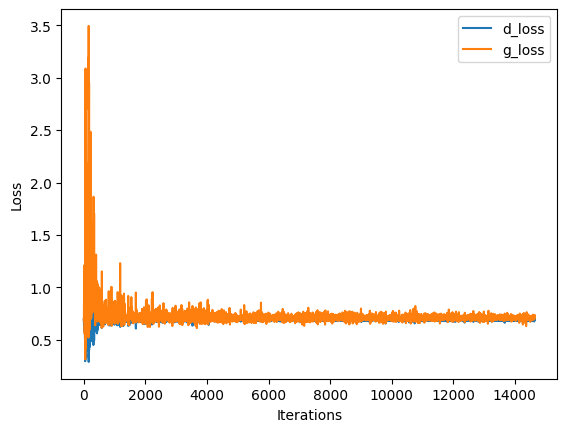

In [39]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses), len(d_losses))
gx = np.linspace(0,len(g_losses), len(g_losses))

# Plot the training loss of G and D
plt.plot(dx, d_losses)
plt.plot(gx, g_losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

8x8

In [41]:
GAN_4x4 = keras.models.load_model('/content/4x4_GAN_epoch_149')
GAN_4x4.summary(show_trainable=True)
gen_4x4 = GAN_4x4.get_layer('model_24')
dis_4x4 = GAN_4x4.get_layer('model_20')

Model: "sequential_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 model_24 (Functional)       (None, 4, 4, 3)           5777923   Y          
                                                                            
 model_20 (Functional)       (None, 1)                 3282689   N          
                                                                            
Total params: 9,060,612
Trainable params: 5,777,923
Non-trainable params: 3,282,689
____________________________________________________________________________


In [42]:
gen_8x8 = add_gen_block(gen_4x4, num_filters=256)
gen_8x8.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_75 (Conv2D)          (None, 4, 4, 512)         2359808   
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_76 (Conv2D)          (None, 4, 4, 512)         235

In [43]:
dis_8x8 = add_dis_block(dis_4x4)
dis_8x8.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 8, 8, 3)]         0         
                                                                 
 conv2d_90 (Conv2D)          (None, 8, 8, 256)         1024      
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_91 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_92 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 8, 8, 256)         0  

In [44]:
# Size of the latent space
latent_dim = 128
epochs = 151
batch_size = 512

# Initialize an optimizer. Pick one.
opt = Adam(learning_rate=0.0001, beta_1=0.5) # Adam optimizer with customized values (for the best result)
# opt = Adam() # Adam optimizer with default values
# opt = SGD() # SGD optimizer with default values

# Discriminator
dis_8x8.trainable = True
dis_8x8.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])



#Define GAN
dis_8x8.trainable = False
GAN_8x8 = define_gan(gen_8x8, dis_8x8)
GAN_8x8.compile(loss = 'binary_crossentropy', optimizer = opt)

#Load real samples
ds = norm_sample()
ds_8x8 = resizeXReal(ds, imgSize = 8)._numpy()

#Train
d_losses_8, g_losses_8 = train(gen_8x8, dis_8x8, GAN_8x8, ds_8x8, latent_dim, epochs, batch_size)


8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 1/97, D_loss = 0.696, G_loss = 0.679
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 2/97, D_loss = 0.595, G_loss = 0.615
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 3/97, D_loss = 0.741, G_loss = 0.598
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 4/97, D_loss = 0.648, G_loss = 0.675
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 5/97, D_loss = 0.572, G_loss = 0.726
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 6/97, D_loss = 0.558, G_loss = 0.801
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 7/97, D_loss = 0.519, G_loss = 0.831
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 8/97, D_loss = 0.733, G_loss = 0.926
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 9/97, D_loss = 0.713, G_loss = 1.330
8/8 [==============================] 

8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 1/97, D_loss = 0.689, G_loss = 0.757
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 2/97, D_loss = 0.692, G_loss = 0.789
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 3/97, D_loss = 0.680, G_loss = 0.844
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 4/97, D_loss = 0.676, G_loss = 0.843
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 5/97, D_loss = 0.672, G_loss = 0.884
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 6/97, D_loss = 0.694, G_loss = 0.808
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 7/97, D_loss = 0.701, G_loss = 0.698
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 8/97, D_loss = 0.714, G_loss = 0.662
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 9/97, D_loss = 0.703, G_loss = 0.670
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 1/97, D_loss = 0.670, G_loss = 0.694
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 2/97, D_loss = 0.669, G_loss = 0.691
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 3/97, D_loss = 0.669, G_loss = 0.724
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 4/97, D_loss = 0.679, G_loss = 0.766
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 5/97, D_loss = 0.689, G_loss = 0.775
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 6/97, D_loss = 0.703, G_loss = 0.777
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 7/97, D_loss = 0.688, G_loss = 0.731
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 8/97, D_loss = 0.677, G_loss = 0.680
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 9/97, D_loss = 0.673, G_loss = 0.662
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 1/97, D_loss = 0.677, G_loss = 0.765
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 2/97, D_loss = 0.682, G_loss = 0.732
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 3/97, D_loss = 0.682, G_loss = 0.697
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 4/97, D_loss = 0.679, G_loss = 0.695
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 5/97, D_loss = 0.674, G_loss = 0.709
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 6/97, D_loss = 0.689, G_loss = 0.739
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 7/97, D_loss = 0.697, G_loss = 0.732
8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 8/97, D_loss = 0.694, G_loss = 0.710
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 9/97, D_loss = 0.698, G_loss = 0.681
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 1/97, D_loss = 0.685, G_loss = 0.759
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 2/97, D_loss = 0.683, G_loss = 0.768
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 3/97, D_loss = 0.684, G_loss = 0.773
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 4/97, D_loss = 0.684, G_loss = 0.750
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 5/97, D_loss = 0.690, G_loss = 0.717
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 6/97, D_loss = 0.695, G_loss = 0.719
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 7/97, D_loss = 0.694, G_loss = 0.731
8/8 [==============================] - 0s 2ms/step
Epoch 41, Iteration 8/97, D_loss = 0.690, G_loss = 0.717
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 9/97, D_loss = 0.696, G_loss = 0.709
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 1/97, D_loss = 0.689, G_loss = 0.752
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 2/97, D_loss = 0.697, G_loss = 0.768
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 3/97, D_loss = 0.693, G_loss = 0.752
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 4/97, D_loss = 0.698, G_loss = 0.722
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 5/97, D_loss = 0.698, G_loss = 0.722
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 6/97, D_loss = 0.696, G_loss = 0.744
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 7/97, D_loss = 0.701, G_loss = 0.675
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 8/97, D_loss = 0.704, G_loss = 0.676
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 9/97, D_loss = 0.697, G_loss = 0.743
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 1/97, D_loss = 0.695, G_loss = 0.698
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 2/97, D_loss = 0.686, G_loss = 0.687
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 3/97, D_loss = 0.679, G_loss = 0.679
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 4/97, D_loss = 0.690, G_loss = 0.710
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 5/97, D_loss = 0.692, G_loss = 0.725
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 6/97, D_loss = 0.699, G_loss = 0.728
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 7/97, D_loss = 0.696, G_loss = 0.735
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 8/97, D_loss = 0.697, G_loss = 0.740
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 9/97, D_loss = 0.695, G_loss = 0.728
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 1/97, D_loss = 0.698, G_loss = 0.678
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 2/97, D_loss = 0.693, G_loss = 0.669
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 3/97, D_loss = 0.687, G_loss = 0.685
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 4/97, D_loss = 0.682, G_loss = 0.731
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 5/97, D_loss = 0.679, G_loss = 0.741
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 6/97, D_loss = 0.688, G_loss = 0.704
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 7/97, D_loss = 0.691, G_loss = 0.676
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 8/97, D_loss = 0.691, G_loss = 0.703
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 9/97, D_loss = 0.692, G_loss = 0.751
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 1/97, D_loss = 0.690, G_loss = 0.758
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 2/97, D_loss = 0.688, G_loss = 0.727
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 3/97, D_loss = 0.690, G_loss = 0.698
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 4/97, D_loss = 0.682, G_loss = 0.721
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 5/97, D_loss = 0.688, G_loss = 0.717
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 6/97, D_loss = 0.682, G_loss = 0.729
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 7/97, D_loss = 0.691, G_loss = 0.800
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 8/97, D_loss = 0.694, G_loss = 0.719
8/8 [==============================] - 0s 2ms/step
Epoch 81, Iteration 9/97, D_loss = 0.683, G_loss = 0.697
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 1/97, D_loss = 0.690, G_loss = 0.677
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 2/97, D_loss = 0.688, G_loss = 0.722
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 3/97, D_loss = 0.686, G_loss = 0.777
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 4/97, D_loss = 0.689, G_loss = 0.795
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 5/97, D_loss = 0.695, G_loss = 0.750
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 6/97, D_loss = 0.692, G_loss = 0.763
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 7/97, D_loss = 0.699, G_loss = 0.726
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 8/97, D_loss = 0.700, G_loss = 0.734
8/8 [==============================] - 0s 2ms/step
Epoch 91, Iteration 9/97, D_loss = 0.690, G_loss = 0.724
8/8 [=======================

8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 1/97, D_loss = 0.690, G_loss = 0.685
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 2/97, D_loss = 0.699, G_loss = 0.713
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 3/97, D_loss = 0.699, G_loss = 0.699
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 4/97, D_loss = 0.689, G_loss = 0.705
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 5/97, D_loss = 0.688, G_loss = 0.758
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 6/97, D_loss = 0.691, G_loss = 0.744
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 7/97, D_loss = 0.683, G_loss = 0.723
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 8/97, D_loss = 0.685, G_loss = 0.718
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 9/97, D_loss = 0.695, G_loss = 0.718
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 1/97, D_loss = 0.696, G_loss = 0.748
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 2/97, D_loss = 0.696, G_loss = 0.697
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 3/97, D_loss = 0.689, G_loss = 0.685
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 4/97, D_loss = 0.692, G_loss = 0.726
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 5/97, D_loss = 0.691, G_loss = 0.717
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 6/97, D_loss = 0.693, G_loss = 0.706
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 7/97, D_loss = 0.697, G_loss = 0.693
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 8/97, D_loss = 0.695, G_loss = 0.684
8/8 [==============================] - 0s 2ms/step
Epoch 111, Iteration 9/97, D_loss = 0.692, G_loss = 0.668
8/8 [==============

8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 1/97, D_loss = 0.687, G_loss = 0.747
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 2/97, D_loss = 0.686, G_loss = 0.699
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 3/97, D_loss = 0.691, G_loss = 0.702
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 4/97, D_loss = 0.694, G_loss = 0.774
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 5/97, D_loss = 0.685, G_loss = 0.753
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 6/97, D_loss = 0.696, G_loss = 0.730
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 7/97, D_loss = 0.697, G_loss = 0.738
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 8/97, D_loss = 0.693, G_loss = 0.695
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 9/97, D_loss = 0.693, G_loss = 0.705
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 1/97, D_loss = 0.683, G_loss = 0.742
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 2/97, D_loss = 0.683, G_loss = 0.702
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 3/97, D_loss = 0.695, G_loss = 0.677
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 4/97, D_loss = 0.691, G_loss = 0.661
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 5/97, D_loss = 0.697, G_loss = 0.690
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 6/97, D_loss = 0.694, G_loss = 0.719
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 7/97, D_loss = 0.689, G_loss = 0.734
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 8/97, D_loss = 0.689, G_loss = 0.743
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 9/97, D_loss = 0.692, G_loss = 0.748
8/8 [==============

8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 1/97, D_loss = 0.689, G_loss = 0.692
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 2/97, D_loss = 0.698, G_loss = 0.715
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 3/97, D_loss = 0.685, G_loss = 0.740
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 4/97, D_loss = 0.695, G_loss = 0.732
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 5/97, D_loss = 0.693, G_loss = 0.712
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 6/97, D_loss = 0.686, G_loss = 0.705
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 7/97, D_loss = 0.693, G_loss = 0.722
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 8/97, D_loss = 0.691, G_loss = 0.738
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 9/97, D_loss = 0.683, G_loss = 0.739
8/8 [==============

8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 1/97, D_loss = 0.691, G_loss = 0.765
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 2/97, D_loss = 0.693, G_loss = 0.784
8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 3/97, D_loss = 0.692, G_loss = 0.775
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 4/97, D_loss = 0.720, G_loss = 0.743
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 5/97, D_loss = 0.690, G_loss = 0.724
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 6/97, D_loss = 0.688, G_loss = 0.720
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 7/97, D_loss = 0.671, G_loss = 0.728
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 8/97, D_loss = 0.662, G_loss = 0.753
8/8 [==============================] - 0s 2ms/step
Epoch 151, Iteration 9/97, D_loss = 0.675, G_loss = 0.708
8/8 [==============

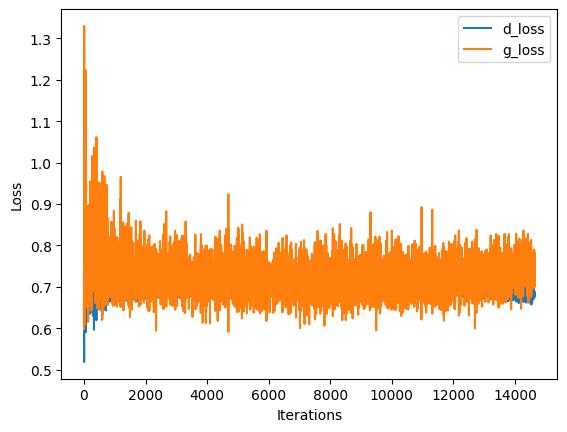

In [45]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses_8), len(d_losses_8))
gx = np.linspace(0,len(g_losses_8), len(g_losses_8))

# Plot the training loss of G and D
plt.plot(dx, d_losses_8)
plt.plot(gx, g_losses_8)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

16x16


In [47]:
GAN_8x8 = keras.models.load_model('/content/8x8_GAN_epoch_149')
GAN_8x8.summary(show_trainable=True)
gen_8x8 = GAN_8x8.get_layer('model_28')
dis_8x8 = GAN_8x8.get_layer('model_29')

Model: "sequential_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 model_28 (Functional)       (None, 8, 8, 3)           7547139   Y          
                                                                            
 model_29 (Functional)       (None, 1)                 4462849   N          
                                                                            
Total params: 12,009,988
Trainable params: 7,547,139
Non-trainable params: 4,462,849
____________________________________________________________________________


In [48]:
gen_16x16 = add_gen_block(gen_8x8, num_filters=256)
gen_16x16.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_75 (Conv2D)          (None, 4, 4, 512)         2359808   
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_76 (Conv2D)          (None, 4, 4, 512)         235

In [49]:
dis_16x16 = add_dis_block(dis_8x8)
dis_16x16.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 16, 16, 3)]       0         
                                                                 
 conv2d_96 (Conv2D)          (None, 16, 16, 256)       1024      
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_97 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 leaky_re_lu_86 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 conv2d_98 (Conv2D)          (None, 16, 16, 256)       590080    
                                                                 
 leaky_re_lu_87 (LeakyReLU)  (None, 16, 16, 256)       0  

In [50]:
# Size of the latent space
latent_dim = 128
epochs = 151
batch_size = 512

# Initialize an optimizer. Pick one.
opt = Adam(learning_rate=0.0001, beta_1=0.5) # Adam optimizer with customized values (for the best result)
# opt = Adam() # Adam optimizer with default values
# opt = SGD() # SGD optimizer with default values

# Discriminator
dis_16x16.trainable = True
dis_16x16.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

#Generator

#Define GAN
dis_16x16.trainable = False
GAN_16x16 = define_gan(gen_16x16, dis_16x16)
GAN_16x16.compile(loss = 'binary_crossentropy', optimizer = opt)

#Load real samples
ds = norm_sample()
ds_16x16 = resizeXReal(ds, imgSize = 16)._numpy()

#Train
d_losses_16, g_losses_16 = train(gen_16x16, dis_16x16, GAN_16x16, ds_16x16, latent_dim, epochs, batch_size)


8/8 [==============================] - 0s 3ms/step
Epoch 1, Iteration 1/97, D_loss = 0.746, G_loss = 0.706
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 2/97, D_loss = 0.682, G_loss = 0.709
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 3/97, D_loss = 0.640, G_loss = 0.634
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 4/97, D_loss = 1.232, G_loss = 0.633
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 5/97, D_loss = 0.701, G_loss = 0.586
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 6/97, D_loss = 0.676, G_loss = 0.684
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 7/97, D_loss = 0.616, G_loss = 0.854
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 8/97, D_loss = 0.564, G_loss = 0.994
8/8 [==============================] - 0s 2ms/step
Epoch 1, Iteration 9/97, D_loss = 0.631, G_loss = 0.864
8/8 [==============================] 

8/8 [==============================] - 0s 3ms/step
Epoch 11, Iteration 1/97, D_loss = 0.695, G_loss = 0.694
8/8 [==============================] - 0s 3ms/step
Epoch 11, Iteration 2/97, D_loss = 0.691, G_loss = 0.715
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 3/97, D_loss = 0.687, G_loss = 0.735
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 4/97, D_loss = 0.688, G_loss = 0.735
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 5/97, D_loss = 0.693, G_loss = 0.778
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 6/97, D_loss = 0.683, G_loss = 0.762
8/8 [==============================] - 0s 3ms/step
Epoch 11, Iteration 7/97, D_loss = 0.678, G_loss = 0.678
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 8/97, D_loss = 0.707, G_loss = 0.776
8/8 [==============================] - 0s 2ms/step
Epoch 11, Iteration 9/97, D_loss = 0.679, G_loss = 0.747
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 1/97, D_loss = 0.689, G_loss = 0.729
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 2/97, D_loss = 0.688, G_loss = 0.731
8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 3/97, D_loss = 0.678, G_loss = 0.731
8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 4/97, D_loss = 0.686, G_loss = 0.676
8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 5/97, D_loss = 0.696, G_loss = 0.647
8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 6/97, D_loss = 0.695, G_loss = 0.675
8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 7/97, D_loss = 0.681, G_loss = 0.706
8/8 [==============================] - 0s 3ms/step
Epoch 21, Iteration 8/97, D_loss = 0.683, G_loss = 0.727
8/8 [==============================] - 0s 2ms/step
Epoch 21, Iteration 9/97, D_loss = 0.680, G_loss = 0.721
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 1/97, D_loss = 0.697, G_loss = 0.746
8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 2/97, D_loss = 0.693, G_loss = 0.702
8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 3/97, D_loss = 0.688, G_loss = 0.791
8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 4/97, D_loss = 0.689, G_loss = 0.654
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 5/97, D_loss = 0.696, G_loss = 0.711
8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 6/97, D_loss = 0.691, G_loss = 0.728
8/8 [==============================] - 0s 3ms/step
Epoch 31, Iteration 7/97, D_loss = 0.692, G_loss = 0.720
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 8/97, D_loss = 0.681, G_loss = 0.721
8/8 [==============================] - 0s 2ms/step
Epoch 31, Iteration 9/97, D_loss = 0.678, G_loss = 0.753
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 1/97, D_loss = 0.702, G_loss = 0.764
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 2/97, D_loss = 0.710, G_loss = 0.701
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 3/97, D_loss = 0.694, G_loss = 0.711
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 4/97, D_loss = 0.688, G_loss = 0.673
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 5/97, D_loss = 0.701, G_loss = 0.700
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 6/97, D_loss = 0.692, G_loss = 0.739
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 7/97, D_loss = 0.693, G_loss = 0.777
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 8/97, D_loss = 0.680, G_loss = 0.724
8/8 [==============================] - 0s 3ms/step
Epoch 41, Iteration 9/97, D_loss = 0.668, G_loss = 0.776
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 51, Iteration 1/97, D_loss = 0.688, G_loss = 0.708
8/8 [==============================] - 0s 3ms/step
Epoch 51, Iteration 2/97, D_loss = 0.681, G_loss = 0.703
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 3/97, D_loss = 0.689, G_loss = 0.733
8/8 [==============================] - 0s 3ms/step
Epoch 51, Iteration 4/97, D_loss = 0.703, G_loss = 0.708
8/8 [==============================] - 0s 3ms/step
Epoch 51, Iteration 5/97, D_loss = 0.697, G_loss = 0.678
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 6/97, D_loss = 0.704, G_loss = 0.718
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 7/97, D_loss = 0.700, G_loss = 0.707
8/8 [==============================] - 0s 2ms/step
Epoch 51, Iteration 8/97, D_loss = 0.689, G_loss = 0.736
8/8 [==============================] - 0s 3ms/step
Epoch 51, Iteration 9/97, D_loss = 0.680, G_loss = 0.698
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 1/97, D_loss = 0.689, G_loss = 0.719
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 2/97, D_loss = 0.683, G_loss = 0.754
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 3/97, D_loss = 0.684, G_loss = 0.607
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 4/97, D_loss = 0.701, G_loss = 1.048
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 5/97, D_loss = 0.730, G_loss = 0.582
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 6/97, D_loss = 0.700, G_loss = 0.649
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 7/97, D_loss = 0.697, G_loss = 0.703
8/8 [==============================] - 0s 3ms/step
Epoch 61, Iteration 8/97, D_loss = 0.690, G_loss = 0.723
8/8 [==============================] - 0s 2ms/step
Epoch 61, Iteration 9/97, D_loss = 0.688, G_loss = 0.729
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 1/97, D_loss = 0.684, G_loss = 0.786
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 2/97, D_loss = 0.694, G_loss = 0.761
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 3/97, D_loss = 0.687, G_loss = 0.743
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 4/97, D_loss = 0.684, G_loss = 0.726
8/8 [==============================] - 0s 4ms/step
Epoch 71, Iteration 5/97, D_loss = 0.700, G_loss = 0.725
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 6/97, D_loss = 0.695, G_loss = 0.749
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 7/97, D_loss = 0.691, G_loss = 0.714
8/8 [==============================] - 0s 3ms/step
Epoch 71, Iteration 8/97, D_loss = 0.689, G_loss = 0.738
8/8 [==============================] - 0s 2ms/step
Epoch 71, Iteration 9/97, D_loss = 0.683, G_loss = 0.747
8/8 [=======================

8/8 [==============================] - 0s 4ms/step
Epoch 81, Iteration 1/97, D_loss = 0.685, G_loss = 0.829
8/8 [==============================] - 0s 4ms/step
Epoch 81, Iteration 2/97, D_loss = 0.688, G_loss = 0.715
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 3/97, D_loss = 0.700, G_loss = 0.702
8/8 [==============================] - 0s 4ms/step
Epoch 81, Iteration 4/97, D_loss = 0.703, G_loss = 0.730
8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 5/97, D_loss = 0.691, G_loss = 0.722
8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 6/97, D_loss = 0.690, G_loss = 0.724
8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 7/97, D_loss = 0.682, G_loss = 0.747
8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 8/97, D_loss = 0.685, G_loss = 0.697
8/8 [==============================] - 0s 3ms/step
Epoch 81, Iteration 9/97, D_loss = 0.692, G_loss = 0.744
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 1/97, D_loss = 0.691, G_loss = 0.691
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 2/97, D_loss = 0.685, G_loss = 0.757
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 3/97, D_loss = 0.693, G_loss = 0.752
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 4/97, D_loss = 0.689, G_loss = 0.693
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 5/97, D_loss = 0.692, G_loss = 0.694
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 6/97, D_loss = 0.691, G_loss = 0.722
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 7/97, D_loss = 0.690, G_loss = 0.693
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 8/97, D_loss = 0.691, G_loss = 0.692
8/8 [==============================] - 0s 3ms/step
Epoch 91, Iteration 9/97, D_loss = 0.693, G_loss = 0.711
8/8 [=======================

8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 1/97, D_loss = 0.678, G_loss = 0.764
8/8 [==============================] - 0s 4ms/step
Epoch 101, Iteration 2/97, D_loss = 0.688, G_loss = 0.704
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 3/97, D_loss = 0.690, G_loss = 0.709
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 4/97, D_loss = 0.675, G_loss = 0.754
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 5/97, D_loss = 0.676, G_loss = 0.744
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 6/97, D_loss = 0.683, G_loss = 0.738
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 7/97, D_loss = 0.687, G_loss = 0.725
8/8 [==============================] - 0s 3ms/step
Epoch 101, Iteration 8/97, D_loss = 0.699, G_loss = 0.714
8/8 [==============================] - 0s 2ms/step
Epoch 101, Iteration 9/97, D_loss = 0.693, G_loss = 0.734
8/8 [==============

8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 1/97, D_loss = 0.704, G_loss = 0.771
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 2/97, D_loss = 0.686, G_loss = 0.670
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 3/97, D_loss = 0.688, G_loss = 0.684
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 4/97, D_loss = 0.688, G_loss = 0.799
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 5/97, D_loss = 0.676, G_loss = 0.811
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 6/97, D_loss = 0.685, G_loss = 0.751
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 7/97, D_loss = 0.680, G_loss = 0.749
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 8/97, D_loss = 0.682, G_loss = 0.798
8/8 [==============================] - 0s 3ms/step
Epoch 111, Iteration 9/97, D_loss = 0.686, G_loss = 0.744
8/8 [==============

8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 1/97, D_loss = 0.693, G_loss = 0.693
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 2/97, D_loss = 0.693, G_loss = 0.708
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 3/97, D_loss = 0.700, G_loss = 0.760
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 4/97, D_loss = 0.688, G_loss = 0.781
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 5/97, D_loss = 0.685, G_loss = 0.776
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 6/97, D_loss = 0.684, G_loss = 0.757
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 7/97, D_loss = 0.684, G_loss = 0.756
8/8 [==============================] - 0s 3ms/step
Epoch 121, Iteration 8/97, D_loss = 0.682, G_loss = 0.726
8/8 [==============================] - 0s 2ms/step
Epoch 121, Iteration 9/97, D_loss = 0.681, G_loss = 0.709
8/8 [==============

8/8 [==============================] - 0s 3ms/step
Epoch 131, Iteration 1/97, D_loss = 0.686, G_loss = 0.781
8/8 [==============================] - 0s 3ms/step
Epoch 131, Iteration 2/97, D_loss = 0.677, G_loss = 0.750
8/8 [==============================] - 0s 3ms/step
Epoch 131, Iteration 3/97, D_loss = 0.682, G_loss = 0.719
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 4/97, D_loss = 0.674, G_loss = 0.706
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 5/97, D_loss = 0.687, G_loss = 0.705
8/8 [==============================] - 0s 3ms/step
Epoch 131, Iteration 6/97, D_loss = 0.673, G_loss = 0.716
8/8 [==============================] - 0s 3ms/step
Epoch 131, Iteration 7/97, D_loss = 0.687, G_loss = 0.750
8/8 [==============================] - 0s 2ms/step
Epoch 131, Iteration 8/97, D_loss = 0.688, G_loss = 0.779
8/8 [==============================] - 0s 3ms/step
Epoch 131, Iteration 9/97, D_loss = 0.681, G_loss = 0.766
8/8 [==============

8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 1/97, D_loss = 0.677, G_loss = 0.772
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 2/97, D_loss = 0.679, G_loss = 0.705
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 3/97, D_loss = 0.687, G_loss = 0.727
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 4/97, D_loss = 0.699, G_loss = 0.755
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 5/97, D_loss = 0.706, G_loss = 0.763
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 6/97, D_loss = 0.664, G_loss = 0.690
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 7/97, D_loss = 0.673, G_loss = 0.776
8/8 [==============================] - 0s 3ms/step
Epoch 141, Iteration 8/97, D_loss = 0.673, G_loss = 0.835
8/8 [==============================] - 0s 2ms/step
Epoch 141, Iteration 9/97, D_loss = 0.672, G_loss = 0.802
8/8 [==============

8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 1/97, D_loss = 0.673, G_loss = 0.771
8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 2/97, D_loss = 0.668, G_loss = 0.782
8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 3/97, D_loss = 0.659, G_loss = 0.817
8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 4/97, D_loss = 0.671, G_loss = 0.909
8/8 [==============================] - 0s 4ms/step
Epoch 151, Iteration 5/97, D_loss = 0.681, G_loss = 0.834
8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 6/97, D_loss = 0.691, G_loss = 0.756
8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 7/97, D_loss = 0.712, G_loss = 0.777
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 8/97, D_loss = 0.692, G_loss = 0.767
8/8 [==============================] - 0s 3ms/step
Epoch 151, Iteration 9/97, D_loss = 0.690, G_loss = 0.723
8/8 [==============

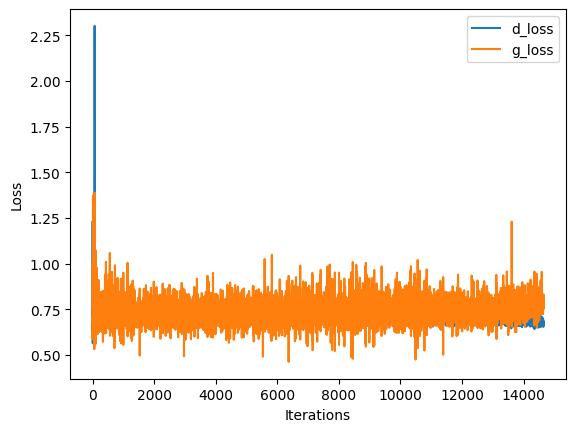

In [51]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses_16), len(d_losses_16))
gx = np.linspace(0,len(g_losses_16), len(g_losses_16))

# Plot the training loss of G and D
plt.plot(dx, d_losses_16)
plt.plot(gx, g_losses_16)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

In [54]:
GAN_16x16 = keras.models.load_model('/content/16x16_GAN_epoch_149')
GAN_16x16.summary(show_trainable=True)
gen_16x16 = GAN_16x16.get_layer('model_30')
dis_16x16 = GAN_16x16.get_layer('model_31')

Model: "sequential_4"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 model_30 (Functional)       (None, 16, 16, 3)         8727299   Y          
                                                                            
 model_31 (Functional)       (None, 1)                 5643009   N          
                                                                            
Total params: 14,370,308
Trainable params: 8,727,299
Non-trainable params: 5,643,009
____________________________________________________________________________


In [55]:
gen_32x32 = add_gen_block(gen_16x16, num_filters=256)
gen_32x32.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128)]             0         
                                                                 
 dense_6 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_75 (Conv2D)          (None, 4, 4, 512)         2359808   
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 4, 4, 512)         0         
                                                                 
 conv2d_76 (Conv2D)          (None, 4, 4, 512)         235

In [56]:
dis_32x32 = add_dis_block(dis_16x16)
dis_32x32.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_102 (Conv2D)         (None, 32, 32, 256)       1024      
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_103 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 leaky_re_lu_91 (LeakyReLU)  (None, 32, 32, 256)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 32, 32, 256)       590080    
                                                                 
 leaky_re_lu_92 (LeakyReLU)  (None, 32, 32, 256)       0  

In [58]:
# Size of the latent space
latent_dim = 128
epochs = 151
batch_size = 512

# Initialize an optimizer. Pick one.
opt = Adam(learning_rate=0.0001, beta_1=0.5) # Adam optimizer with customized values (for the best result)
# opt = Adam() # Adam optimizer with default values
# opt = SGD() # SGD optimizer with default values

# Discriminator
dis_32x32.trainable = True
dis_32x32.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

#Generator

#Define GAN
dis_32x32.trainable = False
GAN_32x32 = define_gan(gen_32x32, dis_32x32)
GAN_32x32.compile(loss = 'binary_crossentropy', optimizer = opt)

#Load real samples
ds = norm_sample()
ds_32x32 = resizeXReal(ds, imgSize = 32)._numpy()

#Train
d_losses_32, g_losses_32 = train(gen_32x32, dis_32x32, GAN_32x32, ds_32x32, latent_dim, epochs, batch_size)


8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 1/97, D_loss = 0.680, G_loss = 1.049
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 2/97, D_loss = 0.683, G_loss = 0.854
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 3/97, D_loss = 0.669, G_loss = 0.708
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 4/97, D_loss = 0.695, G_loss = 0.821
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 5/97, D_loss = 0.701, G_loss = 0.872
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 6/97, D_loss = 0.681, G_loss = 0.840
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 7/97, D_loss = 0.702, G_loss = 0.896
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 8/97, D_loss = 0.649, G_loss = 0.922
8/8 [==============================] - 0s 5ms/step
Epoch 1, Iteration 9/97, D_loss = 0.682, G_loss = 0.932
8/8 [==============================] 

8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 1/97, D_loss = 0.678, G_loss = 0.789
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 2/97, D_loss = 0.699, G_loss = 0.747
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 3/97, D_loss = 0.710, G_loss = 0.715
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 4/97, D_loss = 0.696, G_loss = 0.696
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 5/97, D_loss = 0.679, G_loss = 0.654
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 6/97, D_loss = 0.677, G_loss = 0.742
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 7/97, D_loss = 0.658, G_loss = 0.693
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 8/97, D_loss = 0.662, G_loss = 0.733
8/8 [==============================] - 0s 5ms/step
Epoch 11, Iteration 9/97, D_loss = 0.683, G_loss = 0.857
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 1/97, D_loss = 0.675, G_loss = 0.698
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 2/97, D_loss = 0.669, G_loss = 0.770
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 3/97, D_loss = 0.694, G_loss = 0.848
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 4/97, D_loss = 0.700, G_loss = 0.555
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 5/97, D_loss = 0.750, G_loss = 0.813
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 6/97, D_loss = 0.696, G_loss = 0.787
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 7/97, D_loss = 0.688, G_loss = 0.785
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 8/97, D_loss = 0.674, G_loss = 0.814
8/8 [==============================] - 0s 5ms/step
Epoch 21, Iteration 9/97, D_loss = 0.670, G_loss = 0.763
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 1/97, D_loss = 0.702, G_loss = 0.783
8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 2/97, D_loss = 0.698, G_loss = 0.755
8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 3/97, D_loss = 0.687, G_loss = 0.740
8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 4/97, D_loss = 0.678, G_loss = 0.719
8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 5/97, D_loss = 0.676, G_loss = 0.715
8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 6/97, D_loss = 0.677, G_loss = 0.713
8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 7/97, D_loss = 0.682, G_loss = 0.720
8/8 [==============================] - 0s 6ms/step
Epoch 31, Iteration 8/97, D_loss = 0.687, G_loss = 0.717
8/8 [==============================] - 0s 5ms/step
Epoch 31, Iteration 9/97, D_loss = 0.695, G_loss = 0.703
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 1/97, D_loss = 0.681, G_loss = 0.678
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 2/97, D_loss = 0.682, G_loss = 0.714
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 3/97, D_loss = 0.676, G_loss = 0.751
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 4/97, D_loss = 0.688, G_loss = 0.764
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 5/97, D_loss = 0.692, G_loss = 0.765
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 6/97, D_loss = 0.677, G_loss = 0.762
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 7/97, D_loss = 0.678, G_loss = 0.786
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 8/97, D_loss = 0.679, G_loss = 0.784
8/8 [==============================] - 0s 5ms/step
Epoch 41, Iteration 9/97, D_loss = 0.669, G_loss = 0.737
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 1/97, D_loss = 0.689, G_loss = 0.793
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 2/97, D_loss = 0.678, G_loss = 0.711
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 3/97, D_loss = 0.680, G_loss = 1.049
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 4/97, D_loss = 0.711, G_loss = 0.749
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 5/97, D_loss = 0.664, G_loss = 0.671
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 6/97, D_loss = 0.703, G_loss = 0.897
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 7/97, D_loss = 0.671, G_loss = 0.955
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 8/97, D_loss = 0.667, G_loss = 0.799
8/8 [==============================] - 0s 5ms/step
Epoch 51, Iteration 9/97, D_loss = 0.695, G_loss = 0.783
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 1/97, D_loss = 0.677, G_loss = 0.802
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 2/97, D_loss = 0.654, G_loss = 0.872
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 3/97, D_loss = 0.630, G_loss = 0.922
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 4/97, D_loss = 0.627, G_loss = 0.915
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 5/97, D_loss = 0.649, G_loss = 0.965
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 6/97, D_loss = 0.618, G_loss = 0.842
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 7/97, D_loss = 0.665, G_loss = 0.988
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 8/97, D_loss = 0.669, G_loss = 0.896
8/8 [==============================] - 0s 5ms/step
Epoch 61, Iteration 9/97, D_loss = 0.651, G_loss = 0.816
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 1/97, D_loss = 0.578, G_loss = 1.058
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 2/97, D_loss = 0.597, G_loss = 1.228
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 3/97, D_loss = 0.582, G_loss = 1.119
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 4/97, D_loss = 0.568, G_loss = 1.002
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 5/97, D_loss = 0.597, G_loss = 1.202
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 6/97, D_loss = 0.612, G_loss = 1.061
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 7/97, D_loss = 0.595, G_loss = 0.975
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 8/97, D_loss = 0.625, G_loss = 1.090
8/8 [==============================] - 0s 5ms/step
Epoch 71, Iteration 9/97, D_loss = 0.593, G_loss = 1.124
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 1/97, D_loss = 0.510, G_loss = 1.402
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 2/97, D_loss = 0.542, G_loss = 1.403
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 3/97, D_loss = 0.582, G_loss = 1.449
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 4/97, D_loss = 0.587, G_loss = 1.264
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 5/97, D_loss = 0.525, G_loss = 1.226
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 6/97, D_loss = 0.550, G_loss = 1.516
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 7/97, D_loss = 0.537, G_loss = 1.168
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 8/97, D_loss = 0.570, G_loss = 1.098
8/8 [==============================] - 0s 5ms/step
Epoch 81, Iteration 9/97, D_loss = 0.534, G_loss = 1.281
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 1/97, D_loss = 0.397, G_loss = 1.893
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 2/97, D_loss = 0.450, G_loss = 1.951
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 3/97, D_loss = 0.418, G_loss = 1.773
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 4/97, D_loss = 0.465, G_loss = 1.655
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 5/97, D_loss = 0.430, G_loss = 2.102
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 6/97, D_loss = 0.389, G_loss = 1.744
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 7/97, D_loss = 0.404, G_loss = 1.782
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 8/97, D_loss = 0.423, G_loss = 1.900
8/8 [==============================] - 0s 5ms/step
Epoch 91, Iteration 9/97, D_loss = 0.430, G_loss = 1.765
8/8 [=======================

8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 1/97, D_loss = 0.297, G_loss = 2.904
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 2/97, D_loss = 0.347, G_loss = 2.373
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 3/97, D_loss = 0.318, G_loss = 2.505
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 4/97, D_loss = 0.307, G_loss = 2.706
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 5/97, D_loss = 0.329, G_loss = 2.600
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 6/97, D_loss = 0.314, G_loss = 2.351
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 7/97, D_loss = 0.337, G_loss = 3.056
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 8/97, D_loss = 0.335, G_loss = 2.342
8/8 [==============================] - 0s 5ms/step
Epoch 101, Iteration 9/97, D_loss = 0.325, G_loss = 2.879
8/8 [==============

8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 1/97, D_loss = 0.258, G_loss = 3.542
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 2/97, D_loss = 0.265, G_loss = 3.131
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 3/97, D_loss = 0.325, G_loss = 4.042
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 4/97, D_loss = 0.340, G_loss = 2.517
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 5/97, D_loss = 0.288, G_loss = 3.039
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 6/97, D_loss = 0.253, G_loss = 3.530
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 7/97, D_loss = 0.259, G_loss = 3.245
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 8/97, D_loss = 0.282, G_loss = 2.692
8/8 [==============================] - 0s 5ms/step
Epoch 111, Iteration 9/97, D_loss = 0.273, G_loss = 3.176
8/8 [==============

8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 1/97, D_loss = 0.212, G_loss = 3.726
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 2/97, D_loss = 0.225, G_loss = 3.465
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 3/97, D_loss = 0.250, G_loss = 4.075
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 4/97, D_loss = 0.246, G_loss = 3.500
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 5/97, D_loss = 0.248, G_loss = 4.372
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 6/97, D_loss = 0.221, G_loss = 3.826
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 7/97, D_loss = 0.267, G_loss = 3.994
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 8/97, D_loss = 0.242, G_loss = 3.614
8/8 [==============================] - 0s 5ms/step
Epoch 121, Iteration 9/97, D_loss = 0.249, G_loss = 3.638
8/8 [==============

8/8 [==============================] - 0s 6ms/step
Epoch 131, Iteration 1/97, D_loss = 0.187, G_loss = 3.844
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 2/97, D_loss = 0.197, G_loss = 4.962
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 3/97, D_loss = 0.221, G_loss = 3.831
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 4/97, D_loss = 0.231, G_loss = 4.145
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 5/97, D_loss = 0.189, G_loss = 4.611
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 6/97, D_loss = 0.207, G_loss = 4.454
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 7/97, D_loss = 0.193, G_loss = 3.870
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 8/97, D_loss = 0.282, G_loss = 4.922
8/8 [==============================] - 0s 5ms/step
Epoch 131, Iteration 9/97, D_loss = 0.212, G_loss = 3.844
8/8 [==============

8/8 [==============================] - 0s 6ms/step
Epoch 141, Iteration 1/97, D_loss = 0.149, G_loss = 5.019
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 2/97, D_loss = 0.173, G_loss = 4.501
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 3/97, D_loss = 0.170, G_loss = 4.824
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 4/97, D_loss = 0.163, G_loss = 4.921
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 5/97, D_loss = 0.169, G_loss = 4.611
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 6/97, D_loss = 0.204, G_loss = 4.812
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 7/97, D_loss = 0.156, G_loss = 5.111
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 8/97, D_loss = 0.142, G_loss = 4.194
8/8 [==============================] - 0s 5ms/step
Epoch 141, Iteration 9/97, D_loss = 0.184, G_loss = 5.711
8/8 [==============

8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 1/97, D_loss = 0.172, G_loss = 4.962
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 2/97, D_loss = 0.169, G_loss = 4.891
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 3/97, D_loss = 0.198, G_loss = 4.573
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 4/97, D_loss = 0.182, G_loss = 5.492
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 5/97, D_loss = 0.144, G_loss = 4.751
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 6/97, D_loss = 0.189, G_loss = 5.413
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 7/97, D_loss = 0.183, G_loss = 4.302
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 8/97, D_loss = 0.180, G_loss = 4.859
8/8 [==============================] - 0s 5ms/step
Epoch 151, Iteration 9/97, D_loss = 0.156, G_loss = 5.466
8/8 [==============

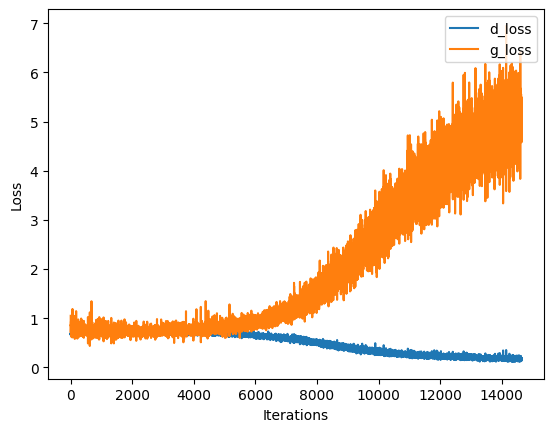

In [59]:
### Plot the training loss of the Generator and the Discriminator over iterations

# Initialize values of x-axis (iterations)
dx = np.linspace(0, len(d_losses_32), len(d_losses_32))
gx = np.linspace(0,len(g_losses_32), len(g_losses_32))

# Plot the training loss of G and D
plt.plot(dx, d_losses_32)
plt.plot(gx, g_losses_32)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['d_loss', 'g_loss'], loc='upper right')
plt.show()

In [60]:
G = keras.models.load_model("/content/G_epoch_149") # Select the Generator model of epoch 299

In [61]:
X_fake, _ = gen_fake(G, 128, 100)

4/4 [==============================] - 0s 5ms/step


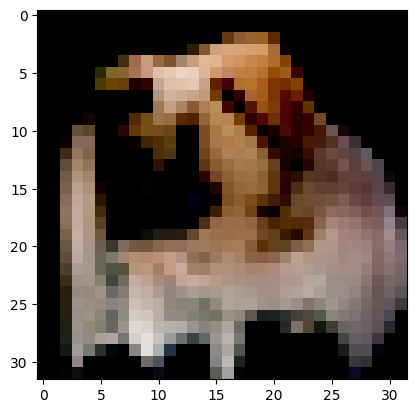

In [65]:
# Visualize the generated images
imgplot = plt.imshow(X_fake[3])
plt.show()


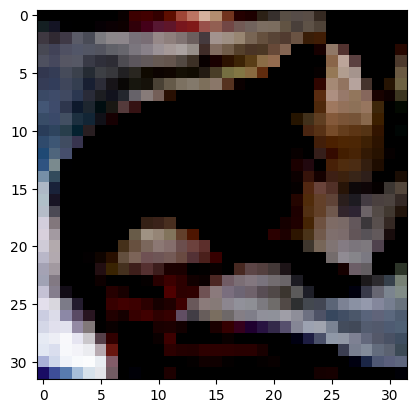

In [80]:
imgplot = plt.imshow(X_fake[42])
plt.show()

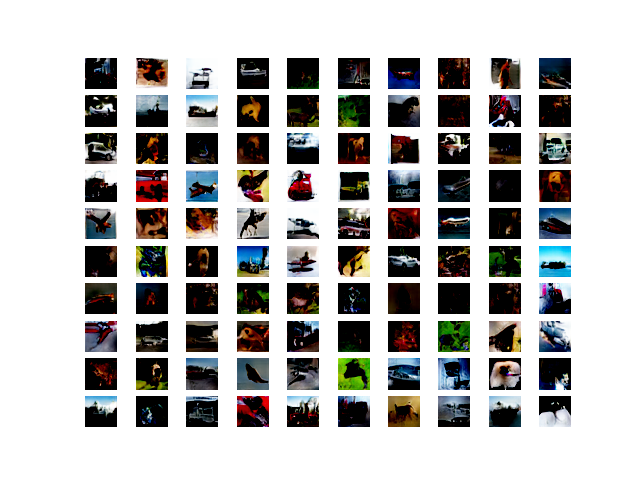

In [66]:
from IPython.display import Image, display
display(Image(filename='Plot_epoch_150.png'))
